In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"warriorrebahan2","key":"07c2db034bcfd063b741f681535a58ee"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d michaelgoh/cicada-species-detection-based-on-acoustic-signals

 99% 128M/129M [00:04<00:00, 39.1MB/s]
100% 129M/129M [00:04<00:00, 31.4MB/s]


In [ ]:
from zipfile import ZipFile

# specifying the zip file name
cicadaZip = "cicada-species-detection-based-on-acoustic-signals.zip"

# opening the zip file in READ mode
with ZipFile(cicadaZip, 'r') as zip_ref:
    zip_ref.extractall("./datasets/")

In [ ]:
pip install pydub

In [ ]:
import os
from pydub import AudioSegment

In [ ]:
import numpy as np
import matplotlib
import scipy

In [ ]:
import librosa

In [ ]:
import networkx as nx

In [ ]:
pip install dtw

  Preparing metadata (setup.py) ... done
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5301 sha256=8851fe8056850dd3d90f8e7b931e23862c66357b4182fda2a84f92b010b7615f
  Stored in directory: /root/.cache/pip/wheels/71/31/62/5e67f6e31521b8cc1652aa58b1ed0c892514d01eeee85fd49c
Successfully built dtw


In [ ]:
# Dynamic Time Warping, compare two mfcc
from dtw import dtw

In [ ]:
from IPython.display import Audio
from IPython.core.display import display
import IPython

In [ ]:
import re

VOLUME WARNING

Cassini 1_4, 1_5, 1_1 Septendecula 3_1, 3_2 Septendecim 2_1

# Making graph

In [ ]:
MFCC_Graph = nx.Graph()

In [ ]:
import math

In [ ]:
DATA_PATH = "/content/datasets/Cicada Species Detection Based on Acoustic Signals/audio (original)"
labels = []
mfcc = []
nthobject_labels = []
object_id = []

for labels_folder in os.listdir(DATA_PATH):
  label_path = os.path.join(DATA_PATH, labels_folder)

  if os.path.isdir(label_path):
    for audio_file in os.listdir(label_path):
      audio_path = os.path.join(label_path, audio_file)

      # Load audio file
      sound = AudioSegment.from_file(audio_path)

      # print(f"{labels_folder} {audio_file}")
      # IPython.display.display(Audio(audio_path))
      # Convert to mono PCM format (16-bit)
      sound = sound.set_channels(1).set_sample_width(2)
      # Export the converted sound back to a WAV file if needed
      sound.export(audio_path, format="wav")

      audio, sr = librosa.load(audio_path)

      mfcc_feat = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
      # Transpose to fix DTW shape error
      mfcc_feat = mfcc_feat.T
      # take only up to 150 for each coefficient
      mfcc_feat = mfcc_feat[:150]
      mfcc.append(mfcc_feat)
      nthobject_labels.append(labels_folder)
      # get file name without .wav extension
      num = re.findall('\d_\d+',audio_file)
      object_id.append(num[0])
      # get file class
      object_label = re.findall('\d',audio_file)
      #                 file name       numeric label
      MFCC_Graph.add_node(num[0], label=int(object_label[0])-1, label_name=labels_folder)

  labels.append(labels_folder)

labels

['cassini', 'septendecula', 'septendecim']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(MFCC_Graph.nodes)

['3_8', '3_12', '3_1', '3_10', '3_4', '3_2', '3_14', '3_13', '3_11', '3_6', '3_3', '3_7', '3_5', '3_9', '1_9', '1_5', '1_3', '1_11', '1_1', '1_6', '1_2', '1_8', '1_12', '1_4', '1_14', '1_7', '1_10', '1_13', '2_14', '2_10', '2_13', '2_1', '2_7', '2_15', '2_8', '2_11', '2_12', '2_3', '2_2', '2_4', '2_6', '2_5', '2_9']


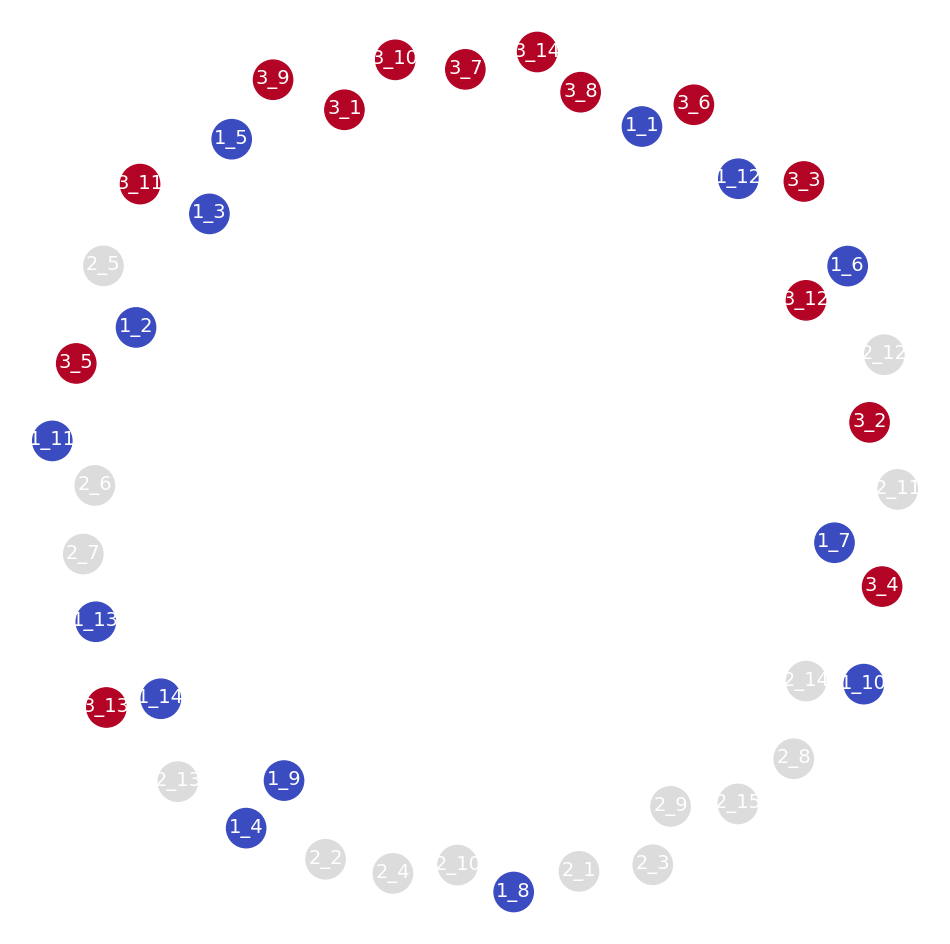

In [ ]:
node_labels = []
for node in MFCC_Graph.nodes:
    label = MFCC_Graph.nodes[node]['label']
    node_labels.append(label)


# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(MFCC_Graph,
                 pos=nx.spring_layout(MFCC_Graph, seed=0),
                 node_color=node_labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [ ]:
labels_np = np.array(labels)

## Distance between the first MFCC coefficient

In [ ]:
I = np.random.permutation(len(mfcc))
def make_edges_dtw_mfcc():
    for node1 in I:
        node1_mfcc = mfcc[node1][:,0]
        node1_mfcc = np.array(node1_mfcc)
        node1_mfcc = np.reshape(node1_mfcc, (node1_mfcc.shape[0],1))

        minDistance, nearestNode = np.inf, -1
        for node2 in I:
            edge_exists = MFCC_Graph.has_edge(object_id[node1], object_id[node2])
            if(object_id[node2]!=object_id[node1] and not edge_exists):

                node2_mfcc = mfcc[node2][:,0]

                node2_mfcc = np.array(node2_mfcc)
                node2_mfcc = np.reshape(node2_mfcc, (node2_mfcc.shape[0],1))
                distance, _, _, _ = dtw(node1_mfcc, node2_mfcc, dist=lambda node1_mfcc,
                                        node2_mfcc: np.linalg.norm(node1_mfcc - node2_mfcc, ord=1))

                if distance < minDistance:
                    minDistance = distance
                    nearestNode = node2

        print(f"the closest node for {nthobject_labels[node1]}num{object_id[node1]} is {nthobject_labels[nearestNode]}num{object_id[nearestNode]} of distance={minDistance}")
        MFCC_Graph.add_edge(object_id[node1],object_id[nearestNode])
make_edges_dtw_mfcc()

the closest node for septendecimnum2_7 is septendecimnum2_13 of distance=312.3102569580078
the closest node for septendeculanum3_5 is septendeculanum3_6 of distance=2902.0223083496094
the closest node for septendeculanum3_8 is septendecimnum2_11 of distance=2272.5550384521484
the closest node for septendecimnum2_9 is septendecimnum2_6 of distance=3371.688377380371
the closest node for cassininum1_6 is septendecimnum2_8 of distance=2777.4759254455566
the closest node for septendecimnum2_15 is septendecimnum2_10 of distance=5576.717010498047
the closest node for cassininum1_10 is septendecimnum2_14 of distance=3204.4395751953125
the closest node for septendecimnum2_4 is septendecimnum2_9 of distance=5483.1168785095215
the closest node for cassininum1_9 is cassininum1_11 of distance=6125.873779296875
the closest node for septendecimnum2_1 is cassininum1_5 of distance=1188.961051940918
the closest node for septendeculanum3_2 is septendeculanum3_1 of distance=1658.5388717651367
the closest 

In [ ]:
mfcc[1].shape

(150, 13)

## The graph

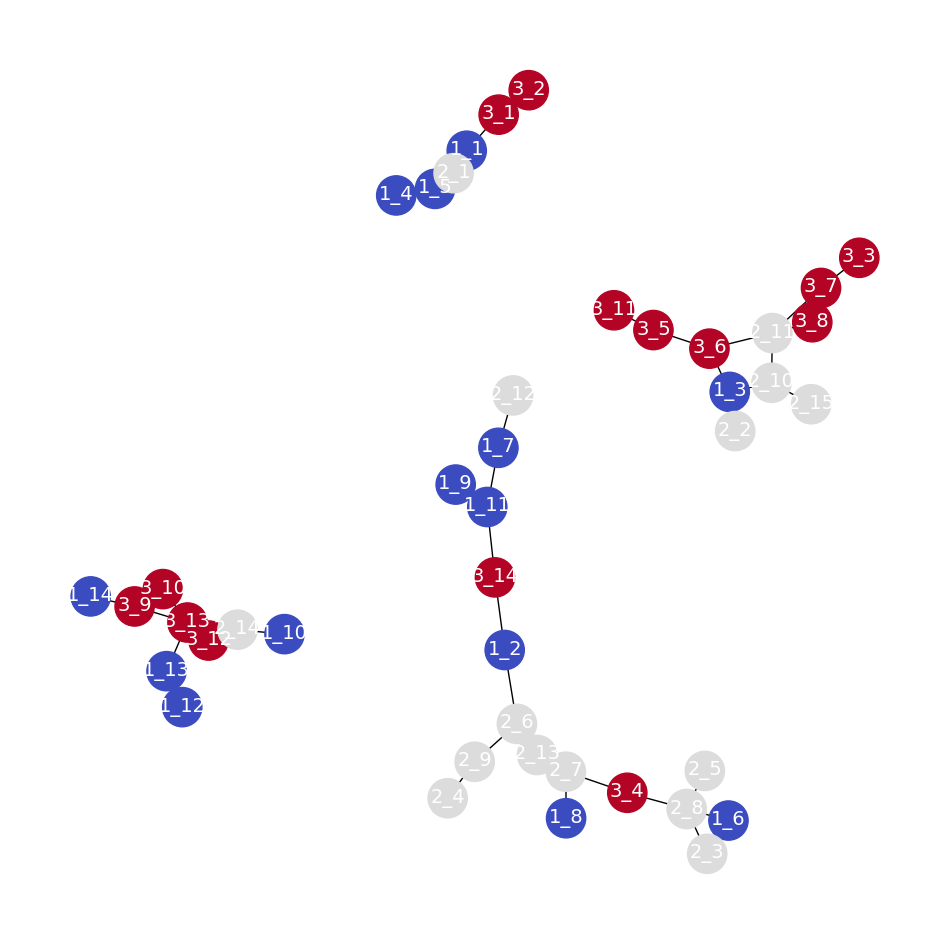

In [ ]:
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(MFCC_Graph,
                 pos=nx.spring_layout(MFCC_Graph, seed=0),
                 node_color=node_labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [ ]:
val_percent = 0.2
n_val = int(val_percent * len(mfcc))

I = np.random.permutation(len(mfcc))
I_val, I_train = I[:n_val], I[n_val:]

In [ ]:
I

array([29, 11,  7,  4, 32, 35, 15,  3, 30, 13, 17, 22, 36, 18, 14, 40, 38,
        6, 10, 37, 25,  0,  5,  2, 27, 34, 39, 42, 12, 26,  1, 16, 33, 41,
       23,  9, 24, 31, 20, 19,  8, 21, 28])

# Adding required attribute for torch_geometric graph

In [ ]:
for i,objct in enumerate(object_id):
    print(i,objct)
    node_x = mfcc[i]
    print(node_x)
    # class_idx = re.findall('\d',objct)
    # print(class_idx[0])
    print(MFCC_Graph.nodes[object_id[i]])
    print(MFCC_Graph.nodes[object_id[i]]['label'])
    MFCC_Graph.nodes[object_id[i]]['x'] = node_x
    MFCC_Graph.nodes[object_id[i]]['y'] = MFCC_Graph.nodes[object_id[i]]['label']
    # print(MFCC_Graph.nodes[object_id[i]])


0 1_10
[[-778.2505       0.           0.        ...    0.           0.
     0.       ]
 [-778.2505       0.           0.        ...    0.           0.
     0.       ]
 [-778.2505       0.           0.        ...    0.           0.
     0.       ]
 ...
 [-216.74078    -51.996986    36.182606  ...   -8.099142    -9.417702
     4.2527924]
 [-215.98396    -52.780914    37.240067  ...   -5.0358043   -6.4796376
     8.483908 ]
 [-215.43015    -54.255272    32.716637  ...   -7.113452   -11.294726
     4.297446 ]]
{'label': 0, 'label_name': 'cassini'}
0
1 1_11
[[-639.5462        0.            0.         ...    0.
     0.            0.        ]
 [-639.5462        0.            0.         ...    0.
     0.            0.        ]
 [-639.5462        0.            0.         ...    0.
     0.            0.        ]
 ...
 [-176.34291     -41.067986     56.60417    ...    2.0053751
     7.5630474    14.023795  ]
 [-193.46985     -45.988106     64.98286    ...    3.0307846
     9.161061     12.623089 

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:00


In [ ]:
import torch_geometric as tg

In [ ]:
MFCC_Graph.edges

EdgeView([('3_8', '2_11'), ('3_12', '2_14'), ('3_12', '3_13'), ('3_1', '3_2'), ('3_1', '1_1'), ('3_10', '3_13'), ('3_4', '2_8'), ('3_4', '2_7'), ('3_14', '1_2'), ('3_14', '1_11'), ('3_13', '1_13'), ('3_13', '3_9'), ('3_13', '2_14'), ('3_11', '3_5'), ('3_6', '1_3'), ('3_6', '2_11'), ('3_6', '3_5'), ('3_3', '3_7'), ('3_7', '2_11'), ('3_9', '1_14'), ('1_9', '1_11'), ('1_5', '1_4'), ('1_5', '2_1'), ('1_5', '1_1'), ('1_3', '2_2'), ('1_3', '2_10'), ('1_11', '1_7'), ('1_1', '2_1'), ('1_6', '2_8'), ('1_2', '2_6'), ('1_8', '2_7'), ('1_12', '1_13'), ('1_7', '2_12'), ('1_10', '2_14'), ('2_10', '2_15'), ('2_10', '2_11'), ('2_13', '2_6'), ('2_13', '2_7'), ('2_7', '2_6'), ('2_8', '2_5'), ('2_8', '2_3'), ('2_4', '2_9'), ('2_6', '2_9')])

In [ ]:
# for
MFCC_Graph.edges(['3_8', 'weight'])

EdgeDataView([('3_8', '1_3')])

# Converting NetworkX graph to torch_geometric graph

In [ ]:
pygraph = tg.utils.convert.from_networkx(MFCC_Graph)

/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/convert.py:260: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  data[key] = torch.tensor(value)


https://stackoverflow.com/questions/70452465/how-to-load-in-graph-from-networkx-into-pytorch-geometric-and-set-node-features

In [ ]:
print(pygraph)
print(pygraph.x)
print(pygraph.y)
print(pygraph.edge_index)

Data(x=[43, 150, 13], edge_index=[2, 86], y=[43], label=[43], label_name=[43])
tensor([[[-8.7611e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-8.7611e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-8.7611e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-2.4181e+02, -9.7051e+00,  2.4545e+00,  ...,  1.5992e+01,
           2.1453e+01,  9.5405e+00],
         [-2.4333e+02, -1.2465e+01, -1.3038e+00,  ...,  1.5502e+01,
           1.6894e+01,  7.9776e+00],
         [-2.4422e+02, -9.5680e+00, -1.0548e+00,  ...,  1.4714e+01,
           1.1948e+01,  7.6403e+00]],

        [[-7.1907e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-7.1907e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-7.1907e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+0

In [ ]:
import torch

In [ ]:
pygraph.y = np.array(pygraph.y)

In [ ]:
pygraph.y = torch.from_numpy(pygraph.y.astype(int))

In [ ]:
pygraph.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# train, test mask indices

In [ ]:
train_ratio = 0.75
num_nodes = pygraph.y.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

np.random.shuffle(idx)
train_mask = torch.full_like(pygraph.y, False, dtype=bool)
train_mask[idx[:num_train]] = True
test_mask = torch.full_like(pygraph.y, False, dtype=bool)
test_mask[idx[num_train:]] = True

print(train_mask)
# tensor([ True, False, False, False, False])
print(test_mask)
# tensor([False,  True,  True,  True,  True])

tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False,  True, False, False,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True])
tensor([False,  True, False, False,  True, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False, False,
        False,  True, False, False, False, False,  True, False,  True,  True,
         True, False, False,  True, False, False, False, False, False, False,
        False,  True, False])


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# GCN 2 Conv

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [ ]:
len(labels)

3

In [ ]:
pygraph.x[0].shape

torch.Size([150, 13])

## creating PyG data object from Graph

In [ ]:
model = GCN(1950, 8, 3)
model, data = model.to(device), pygraph.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.005)  # Only perform weight-decay on first convolution.
print(model)

GCN(
  (conv1): GCNConv(1950, 8)
  (conv2): GCNConv(8, 3)
)


In [ ]:
train_mask

tensor([ True,  True,  True, False, False,  True,  True,  True, False,  True,
         True, False, False,  True, False,  True, False,  True, False,  True,
        False,  True,  True, False,  True,  True,  True, False,  True, False,
        False,  True, False,  True,  True,  True,  True, False, False,  True,
        False,  True, False])

In [ ]:
smallest_dim = float('inf')
for i,_ in enumerate(object_id):
    dim = data.x[i].shape[0]
    # print(data.x[i].shape[0])
    if dim<smallest_dim:
      smallest_dim = dim
print(smallest_dim)

150


In [ ]:
list_of_arrays = [np.array(df[:150].T) for df in data.x]
list_of_arrays = torch.FloatTensor(np.stack(list_of_arrays))
list_of_arrays.shape

torch.Size([43, 13, 150])

In [ ]:
data.x = list_of_arrays
data.x.shape

torch.Size([43, 13, 150])

In [ ]:
flattened = [np.array(torch.flatten(df)) for df in data.x]
flattened = torch.FloatTensor(np.stack(flattened))
flattened.shape

torch.Size([43, 1950])

## Train Test

In [ ]:
model = GCN(1950, 8, 3)
model, data = model.to(device), pygraph.to(device)
loss_hist_GCN2= []
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(flattened, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(flattened, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == data.y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    loss_hist_GCN2.append(loss.detach().numpy())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 150.1204
Epoch: 002, Loss: 290.6030
Epoch: 003, Loss: 45.0904
Epoch: 004, Loss: 40.1410
Epoch: 005, Loss: 2.9839
Epoch: 006, Loss: 16.4022
Epoch: 007, Loss: 17.0691
Epoch: 008, Loss: 22.8932
Epoch: 009, Loss: 5.3605
Epoch: 010, Loss: 17.1779
Epoch: 011, Loss: 9.5541
Epoch: 012, Loss: 11.7470
Epoch: 013, Loss: 7.2969
Epoch: 014, Loss: 2.0133
Epoch: 015, Loss: 7.2152
Epoch: 016, Loss: 6.0785
Epoch: 017, Loss: 4.2620
Epoch: 018, Loss: 5.2308
Epoch: 019, Loss: 8.0890
Epoch: 020, Loss: 2.3421
Epoch: 021, Loss: 5.0025
Epoch: 022, Loss: 3.7655
Epoch: 023, Loss: 3.4527
Epoch: 024, Loss: 3.0932
Epoch: 025, Loss: 2.3760
Epoch: 026, Loss: 6.1773
Epoch: 027, Loss: 5.4035
Epoch: 028, Loss: 2.2557
Epoch: 029, Loss: 7.8517
Epoch: 030, Loss: 3.8469
Epoch: 031, Loss: 5.1778
Epoch: 032, Loss: 2.0158
Epoch: 033, Loss: 8.6664
Epoch: 034, Loss: 2.4541
Epoch: 035, Loss: 2.2359
Epoch: 036, Loss: 2.9959
Epoch: 037, Loss: 1.2617
Epoch: 038, Loss: 2.2419
Epoch: 039, Loss: 0.9274
Epoch: 040, Lo

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.2727


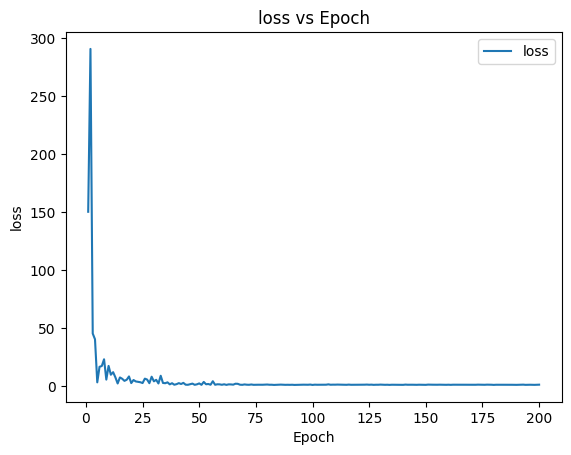

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 201)

plt.plot(epochs_range, loss_hist_GCN2, label='loss')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss vs Epoch')
plt.legend()
plt.show()

# GCN 3 Conv

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(1950, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 32)
        self.conv3 = GCNConv(32, 3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1950, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 3)
)


In [ ]:
loss_hist_GCN3 = []
model = GCN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-5)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(flattened, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(flattened, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == data.y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 401):
    loss = train()
    loss_hist_GCN3.append(loss.detach().numpy())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 103.4380
Epoch: 002, Loss: 411.1701
Epoch: 003, Loss: 157.0923
Epoch: 004, Loss: 220.3290
Epoch: 005, Loss: 173.1826
Epoch: 006, Loss: 181.2421
Epoch: 007, Loss: 127.8838
Epoch: 008, Loss: 118.7646
Epoch: 009, Loss: 115.6077
Epoch: 010, Loss: 171.2040
Epoch: 011, Loss: 69.6862
Epoch: 012, Loss: 112.6014
Epoch: 013, Loss: 86.3715
Epoch: 014, Loss: 100.8011
Epoch: 015, Loss: 61.0428
Epoch: 016, Loss: 62.8413
Epoch: 017, Loss: 56.4908
Epoch: 018, Loss: 24.5014
Epoch: 019, Loss: 40.2946
Epoch: 020, Loss: 30.1153
Epoch: 021, Loss: 17.1339
Epoch: 022, Loss: 19.2687
Epoch: 023, Loss: 12.9582
Epoch: 024, Loss: 18.5344
Epoch: 025, Loss: 19.0500
Epoch: 026, Loss: 17.4458
Epoch: 027, Loss: 19.1416
Epoch: 028, Loss: 16.8529
Epoch: 029, Loss: 7.6590
Epoch: 030, Loss: 10.2439
Epoch: 031, Loss: 11.3549
Epoch: 032, Loss: 5.6356
Epoch: 033, Loss: 21.8599
Epoch: 034, Loss: 5.3427
Epoch: 035, Loss: 4.8951
Epoch: 036, Loss: 6.3208
Epoch: 037, Loss: 13.4987
Epoch: 038, Loss: 5.6451
Epoch:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5455


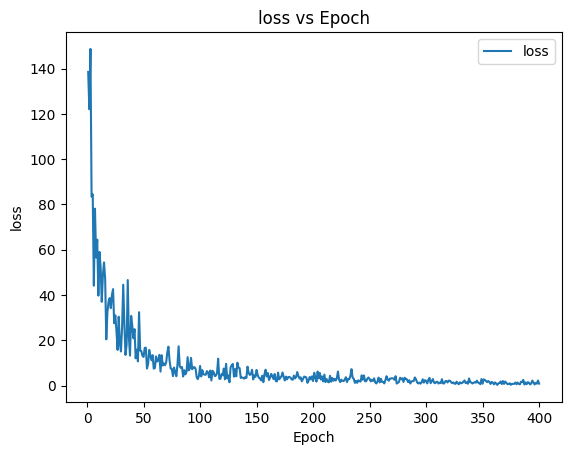

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 401)

plt.plot(epochs_range, loss_hist_GCN3, label='loss')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss vs Epoch')
plt.legend()
plt.show()

# GAT 2

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_channels, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels * heads,out_channels, heads=1,
                             concat=False)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GAT(1950, 8, 3, 8)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=5e-4, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
loss_hist_GAT = []

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(flattened, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(flattened, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == data.y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 401):
    loss = train()
    loss_hist_GAT.append(loss.detach().numpy())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 178.0095
Epoch: 002, Loss: 185.7991
Epoch: 003, Loss: 150.8029
Epoch: 004, Loss: 130.5215
Epoch: 005, Loss: 168.1007
Epoch: 006, Loss: 184.2680
Epoch: 007, Loss: 124.2330
Epoch: 008, Loss: 148.7079
Epoch: 009, Loss: 181.1398
Epoch: 010, Loss: 125.4746
Epoch: 011, Loss: 128.9823
Epoch: 012, Loss: 141.0028
Epoch: 013, Loss: 126.8120
Epoch: 014, Loss: 116.5760
Epoch: 015, Loss: 94.1247
Epoch: 016, Loss: 73.3572
Epoch: 017, Loss: 164.6427
Epoch: 018, Loss: 169.4259
Epoch: 019, Loss: 123.2265
Epoch: 020, Loss: 130.9925
Epoch: 021, Loss: 119.7082
Epoch: 022, Loss: 154.2486
Epoch: 023, Loss: 83.3342
Epoch: 024, Loss: 113.6720
Epoch: 025, Loss: 102.0964
Epoch: 026, Loss: 85.2887
Epoch: 027, Loss: 116.3680
Epoch: 028, Loss: 108.4626
Epoch: 029, Loss: 84.6439
Epoch: 030, Loss: 145.3241
Epoch: 031, Loss: 79.4277
Epoch: 032, Loss: 101.7733
Epoch: 033, Loss: 77.3363
Epoch: 034, Loss: 62.8616
Epoch: 035, Loss: 116.4696
Epoch: 036, Loss: 63.1107
Epoch: 037, Loss: 63.2455
Epoch: 038,

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7273


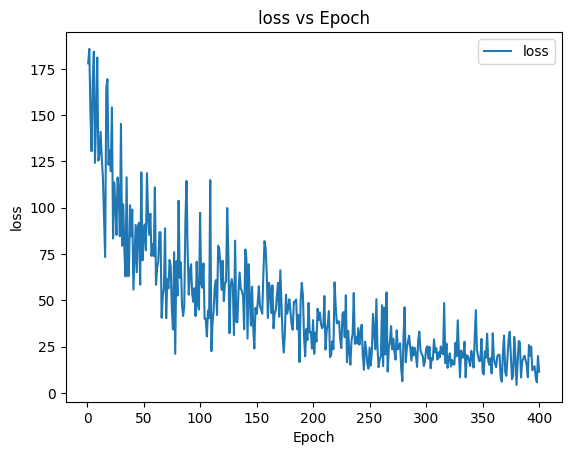

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 401)

plt.plot(epochs_range, loss_hist_GAT, label='loss')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss vs Epoch')
plt.legend()
plt.show()

# GraphMix

In [ ]:
from torch_geometric.nn import GINConv, GraphNorm

In [ ]:
class GraphMix(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphMix, self).__init__()

        # First GCN Layer
        self.gcn1 = GCNConv(in_channels, hidden_channels)

        # Second GCN Layer
        self.gcn2 = GCNConv(hidden_channels, 64)
        # self.gat1 = GATConv(64, 16, 4)
        self.gcn3 = GCNConv(64, 32)

        # GIN Layer
        self.gin = GINConv(torch.nn.Sequential(torch.nn.Linear(32,
                                                out_channels),torch.nn.ReLU()))
        # GraphNorm Layer
        self.graphnorm = GraphNorm(out_channels)

    def forward(self, x, edge_index):

        # First GCN Layer
        x = F.relu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.4, training=self.training)
        # Second GCN Layer
        x = F.relu(self.gcn2(x, edge_index))
        x = F.dropout(x, p=0.25, training=self.training)
        # x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        # GIN Layer
        x = F.relu(self.gin(x, edge_index))
        # GraphNorm Layer
        x = self.graphnorm(x)

        return x




In [ ]:
def gnn_model_summary(model):

    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0]
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [ ]:
model_GraphMix = GraphMix(in_channels=1950, hidden_channels=128, out_channels=3)
gnn_model_summary(model_GraphMix)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
           gcn1.bias                      [128]             128
     gcn1.lin.weight                [128, 1950]          249600
           gcn2.bias                       [64]              64
     gcn2.lin.weight                  [64, 128]            8192
           gcn3.bias                       [32]              32
     gcn3.lin.weight                   [32, 64]            2048
     gin.nn.0.weight                    [3, 32]              96
       gin.nn.0.bias                        [3]               3
    graphnorm.weight                        [3]               3
      graphnorm.bias                        [3]               3
graphnorm.mean_scale                        [3]               3
----------------------------------------------------------------
Total params: 260172
Trainable params

In [ ]:
model_GraphMix = GraphMix(in_channels=1950, hidden_channels=128, out_channels=3)
optimizer = torch.optim.Adam(model_GraphMix.parameters(),
                             lr=0.005
                             , weight_decay=5e-5)
criterion = torch.nn.CrossEntropyLoss()
loss_hist_GMix = []

def train():
      model_GraphMix.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_GraphMix(flattened, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model_GraphMix.eval()
      out = model_GraphMix(flattened, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == data.y[test_mask]  # Check against ground-truth labels.
      print(f"{pred[test_mask]}, actual: {data.y[test_mask]}")
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 1001):
    loss = train()
    loss_hist_GMix.append(loss.detach().numpy())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.1105
Epoch: 002, Loss: 0.9223
Epoch: 003, Loss: 1.0356
Epoch: 004, Loss: 1.0420
Epoch: 005, Loss: 1.0150
Epoch: 006, Loss: 0.9958
Epoch: 007, Loss: 0.9770
Epoch: 008, Loss: 0.9765
Epoch: 009, Loss: 1.0003
Epoch: 010, Loss: 0.9670
Epoch: 011, Loss: 0.9913
Epoch: 012, Loss: 0.9753
Epoch: 013, Loss: 0.9524
Epoch: 014, Loss: 0.9496
Epoch: 015, Loss: 0.9744
Epoch: 016, Loss: 0.9543
Epoch: 017, Loss: 0.9290
Epoch: 018, Loss: 0.9514
Epoch: 019, Loss: 0.9834
Epoch: 020, Loss: 0.9065
Epoch: 021, Loss: 0.9747
Epoch: 022, Loss: 0.9162
Epoch: 023, Loss: 0.9084
Epoch: 024, Loss: 0.9694
Epoch: 025, Loss: 0.9406
Epoch: 026, Loss: 0.9336
Epoch: 027, Loss: 0.8913
Epoch: 028, Loss: 0.9730
Epoch: 029, Loss: 0.8599
Epoch: 030, Loss: 0.8693
Epoch: 031, Loss: 0.8497
Epoch: 032, Loss: 0.8512
Epoch: 033, Loss: 0.8376
Epoch: 034, Loss: 0.8815
Epoch: 035, Loss: 0.8515
Epoch: 036, Loss: 0.8744
Epoch: 037, Loss: 0.8204
Epoch: 038, Loss: 0.8802
Epoch: 039, Loss: 0.9240
Epoch: 040, Loss: 0.8433


Dengan Gat

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

tensor([1, 2, 2, 2, 0, 1, 2, 0, 1, 1, 1]), actual: tensor([2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1])
Test Accuracy: 0.7273


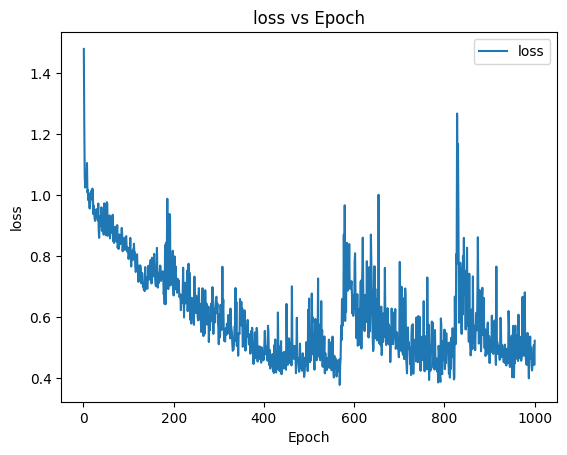

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 1001)

plt.plot(epochs_range, loss_hist_GMix, label='loss')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss vs Epoch')
plt.legend()
plt.show()

 Tanpa Gat

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

tensor([1, 2, 2, 0, 0, 1, 1, 0, 1, 1, 1]), actual: tensor([2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1])
Test Accuracy: 0.7273


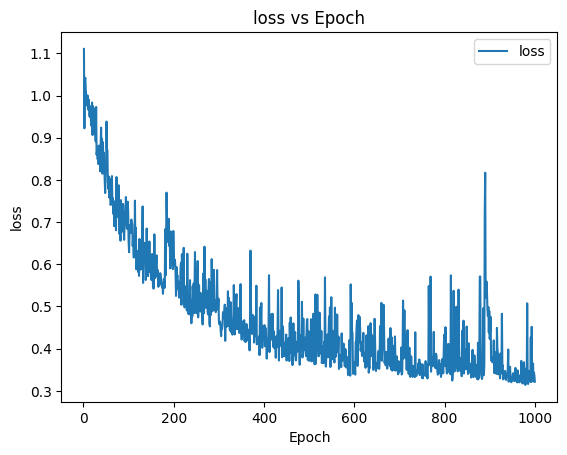

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 1001)

plt.plot(epochs_range, loss_hist_GMix, label='loss')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss vs Epoch')
plt.legend()
plt.show()